# E: Ejemplo real de calibración. Cuarta fase: *lights*

Por último vamos a procesar los *lights* usando los *superbias*, *superdarks* y *superflats* de los anteriores *notebooks*.

Usaremos dos bibliotecas:
  + ```Pandas```, una biblioteca de estructuras de datos y funciones para análisis de datos
  + ```Astroalign```, para alinear fotogramas.

```
> conda install -c anaconda pandas

> conda install -c conda-forge astroalign 
```

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import glob
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import os
import pandas as pd

import scipy

from photutils import DAOStarFinder
from photutils import make_source_mask

from scipy import ndimage, misc

from imstats import imstats

In [2]:
directorioCalibracion = 'salidas/salidaCalibracion/'

superBias = fits.open(directorioCalibracion + "superBias.fit")[0].data
superDark = fits.open(directorioCalibracion + "superDark.fit")[0].data
darkCurrent = fits.open(directorioCalibracion + "darkCurrent.fit")[0].data
superFlat = fits.open(directorioCalibracion + "superFlat.fit")[0].data

## Apertura de los *lights*

In [3]:
#ls imagenes\calibracionImagenes\ha\*.fts

In [4]:
lights_list = sorted(glob.glob('imagenes/calibracionImagenes/ha/*.fit'))
lights_list

['imagenes/calibracionImagenes/ha/NGC2070-20200208@030339-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@031223-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@031915-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@032604-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@033255-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@034446-300S-H-alpha.fit']

In [5]:
hdul_lights = []
for light in lights_list:
    hdul_lights.append(fits.open(light))
hdul_lights[0].info()

Filename: imagenes/calibracionImagenes/ha/NGC2070-20200208@030339-300S-H-alpha.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     124   (4096, 4096)   int16 (rescales to uint16)   


In [6]:
hdul_lights[0][0].header['IMAGETYP']

'Light Frame'

## Inspección de los *lights*

### Usando el *FWHM*

Para la inspección de los *lights* podemos usar *FWHM* (flujo máximo a media altura) para evaluar si nuestras imágenes se han realizado con un buen foco o el si el *seeing* de la noche era bueno.

In [7]:
header_lights = []
FWHM = []
for f in lights_list:
    hdul = fits.open(f)
    header_lights.append(hdul[0].header)
    FWHM.append(hdul[0].header['FWHM'])

In [8]:
header_lights[3]

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2020-02-08T03:27:08' / [ISO 8601] UTC date/time of exposure start    
EXPTIME =   3.00000000000E+002 / [sec] Duration of exposure                     
EXPOSURE=   3.00000000000E+002 / [sec] Duration of exposure                     
SET-TEMP=  -30.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -30.000000000000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

### Mediante inspección visual

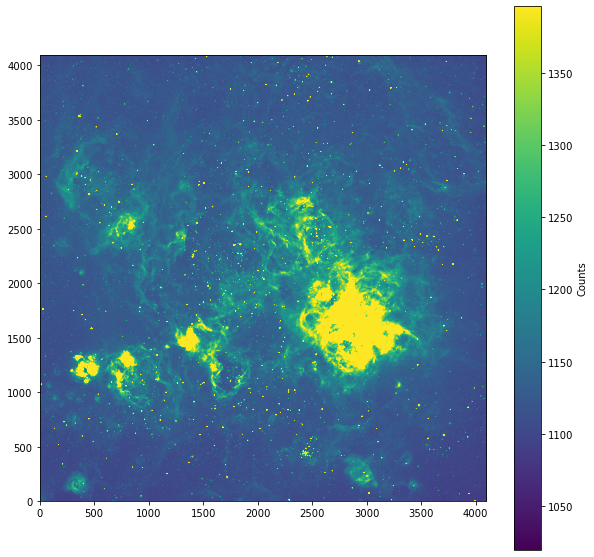

In [9]:
n_imagen = 1
plt.figure(f"Light {lights_list[n_imagen]}", figsize=[10, 10])
plt.imshow(hdul_lights[n_imagen][0].data, vmin=np.min(hdul_lights[n_imagen][0].data), vmax=np.mean(hdul_lights[n_imagen][0].data)*1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

## Eliminación de *lights*

Podemos eliminar *lights* con un alto *FWHM*.

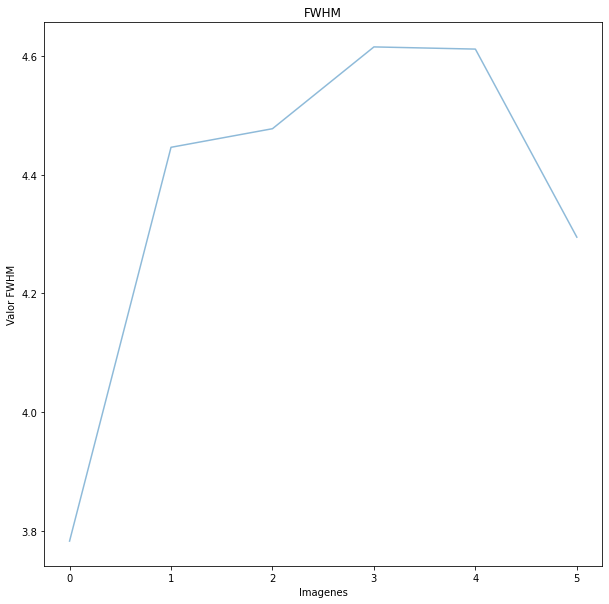

In [10]:
plt.figure("FWHM", figsize=[10, 10])
plt.plot(np.arange(0,len(FWHM)), FWHM, alpha=0.5)#, label='flat normalizado')

plt.title('FWHM')
plt.xlabel('Imagenes')
plt.ylabel('Valor FWHM')
#plt.legend()
#plt.imshow(stacked, vmin=1000, vmax=2000, origin='lower')
#plt.colorbar(label='Counts')
plt.show()

In [11]:
for r in range(len(lights_list)):
    if header_lights[r]['FWHM'] > np.median(FWHM)*1.5:
        print(lights_list[r])
        lights_list.remove(lights_list[r])
        
lights_list

['imagenes/calibracionImagenes/ha/NGC2070-20200208@030339-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@031223-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@031915-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@032604-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@033255-300S-H-alpha.fit',
 'imagenes/calibracionImagenes/ha/NGC2070-20200208@034446-300S-H-alpha.fit']

## Corrección de *lights* con *bias*, *darks* y *flats*

In [12]:
lights_correction = []
for light in range(len(lights_list)):
    light_b = hdul_lights[light][0].data - superBias
    light_bd = light_b - darkCurrent 
    light_bdf = light_bd / superFlat 
    lights_correction.append(light_bdf)

In [13]:
imstats(lights_correction[0])

{'npix': 16777216,
 'min': -34339.97,
 'max': 71468.86,
 'mean': 166.0302,
 'median': 134.40062,
 'std': 279.95047}

## Inspección de pixeles calientes (*hotpixels*)

Una vez corregida nuestra imagen, tendremos valores negativos correspondientes a los *hotpixel* que se encontraban en los *darks*. Es ahora donde los podemos identificar y eliminar sustituyéndolos por el valor medio de los píxeles adyacentes.

In [14]:
for hot in range(len(lights_list)):
    hot_pixeles = np.where(lights_correction[hot] < 0) # hotpixel será un array con la posicion del los hot pixeles
    for i in range(len(hot_pixeles[0])): # 
        lights_correction[hot][hot_pixeles[0][i]][hot_pixeles[1][i]] = np.median([lights_correction[hot][hot_pixeles[0][i]-1, hot_pixeles[1][0]], lights_correction[hot][hot_pixeles[1][i]+1, hot_pixeles[1][0]]]) #lights_correction[hot][hot_pixeles[0][i]-1, hot_pixeles[1][i]]

In [15]:
lights_correction[0][hot_pixeles[0][0], hot_pixeles[1][0]] # comprobacion que ha cambiado de valor

124.89287

In [16]:
imstats(lights_correction[0])

{'npix': 16777216,
 'min': 0.0,
 'max': 71468.86,
 'mean': 166.03761,
 'median': 134.40083,
 'std': 279.79932}

## Detección y eliminación de rayos cósmicos

Usaremos la biblioteca ```astroscrappy``` para eliminar los rayos cósmicos que han llegado a nuestro sensor. Para ello esta biblioteca dispone de varios parámetros que podemos modificar dependiendo de la cámara que usemos y el nivel de señal/ruido al que queramos llegar. Con esto hay que tener cuidado de no eliminar estructura de nuestra imagen.

El método ```detect_cosmics``` ([documentación de astroscrappy](https://astroscrappy.readthedocs.io/en/latest/api/astroscrappy.detect_cosmics.html)) nos devolverá la imagen corregida de rayos cósmicos y una máscara con las partes donde se ha aplicado la corrección.

Para instalar ```astroscrappy```:

```
 > conda install -c conda-forge astroscrappy
```

In [17]:
import astroscrappy

De la documentación de la biblioteca sacamos:

```
astroscrappy.detect_cosmics(indat, inmask=None, inbkg=None, invar=None, sigclip=4.5, sigfrac=0.3, objlim=5.0, gain=1.0, readnoise=6.5, satlevel=65536.0, niter=4, sepmed=True, cleantype='meanmask', fsmode='median', psfmodel='gauss', psffwhm=2.5, psfsize=7, psfk=None, psfbeta=4.765, verbose=False)
```

Parámetros más interesantes:

+ ``indat``: matriz ```numpy```

    Matriz de datos de entrada que se utilizará para la detección de rayos cósmicos. Esto debe incluir el fondo del cielo, para que el ruido pueda estimarse correctamente a partir de los valores de los datos. Esto debe estar en unidades de "recuentos".

+ ``inmask``: matriz ```numpy``` booleana (opcional)

    Máscara de píxeles donde los valores de True se ignorarán en el proceso de limpieza/detección de rayos cósmicos. Predeterminado: ninguno.

+ ``sigclip``: ```float``` (opcional)

    Límite de laplaciano a ruido para la detección de rayos cósmicos. Los valores más bajos marcarán más píxeles como rayos cósmicos. Predeterminado: 4.5.

+ ``sigfrac``: ```float``` (opcional)

    Límite de detección para píxeles vecinos. Para píxeles vecinos de rayos cósmicos, se utilizará un límite de detección de laplacian a ruido de sigfrac * sigclip. Predeterminado: 0.3.

+ ``objlim``: ```float``` (opcional)

    Mínimo contraste entre la imagen laplaciana y la imagen de estructura fina. Aumente este valor si los núcleos de estrellas brillantes están marcados como rayos cósmicos. Predeterminado: 5.0.

+ ``gain``:  ```float``` (opcional)

    Ganancia de la imagen (electrones/ADU). Siempre necesitamos trabajar en electrones para la detección de rayos cósmicos. Predeterminado: 1.0

+ ``readnoise``: ```float``` (opcional)

    Se utiliza para generar el modelo de ruido de la imagen. Predeterminado: 6.5.

+ ``satlevel``: ```float``` (opcional) 

    Saturación de nivel de la imagen (electrones). Este valor se usa para detectar estrellas saturadas y los píxeles en este nivel o por encima se agregan a la máscara. Predeterminado: 65536.0.

+ ``niter``: ```int``` (opcional)

    Número de iteraciones del algoritmo LA Cosmic a realizar. Predeterminado: 4.

+ ``verbose``: ```boolean``` (opcional)

    Ser más explícito imprimiendo información mientras se calcula. Predeterminado: ```False```.

In [18]:
lights_correction_cosmicray = []
mask_cosmicray = []
for image in range(len(lights_list)):
    mask, cosmicray = astroscrappy.detect_cosmics(lights_correction[image], sigclip=6, sigfrac=15, objlim=5.0, gain=1.0, readnoise=6.5, satlevel=65536.0, niter=4, verbose=True)
    lights_correction_cosmicray.append(cosmicray)
    mask_cosmicray.append(mask)

Starting 4 L.A.Cosmic iterations
Iteration 1:
114 cosmic pixels this iteration
Iteration 2:
19 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
184 cosmic pixels this iteration
Iteration 2:
50 cosmic pixels this iteration
Iteration 3:
7 cosmic pixels this iteration
Iteration 4:
0 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
232 cosmic pixels this iteration
Iteration 2:
41 cosmic pixels this iteration
Iteration 3:
7 cosmic pixels this iteration
Iteration 4:
1 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
217 cosmic pixels this iteration
Iteration 2:
44 cosmic pixels this iteration
Iteration 3:
9 cosmic pixels this iteration
Iteration 4:
0 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
411 cosmic pixels this iteration
Iteration 2:
96 cosmic pixels this iteration
Iteration 3:
9 cosmic pixels this iteration
Iteration 4:
0 cosmic pixels

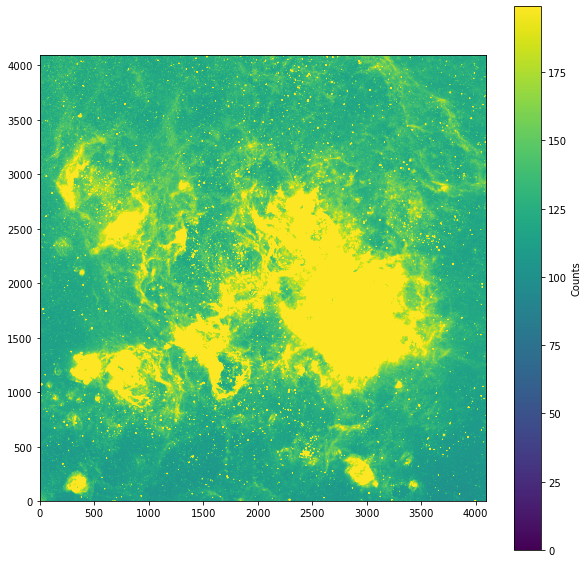

In [19]:
n_imagen = 0
plt.figure(f"Light {lights_list[n_imagen]}", figsize=[10, 10])
plt.imshow(lights_correction_cosmicray[n_imagen], vmin=np.min(lights_correction_cosmicray[n_imagen]), vmax=np.mean(lights_correction_cosmicray[n_imagen])*1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

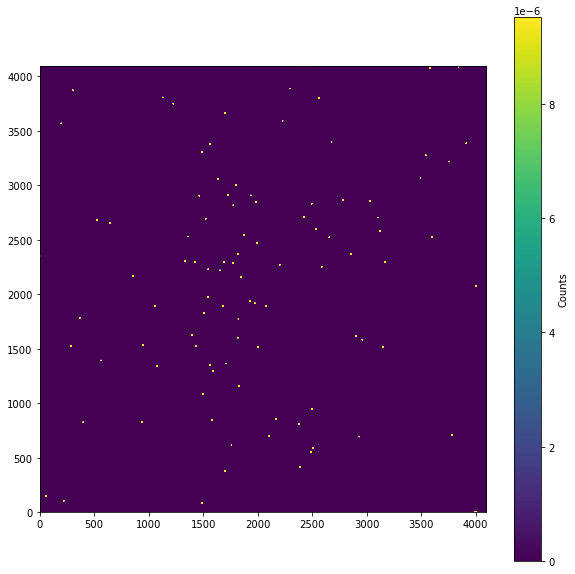

In [20]:
n_imagen = 0
plt.figure(f"Light {lights_list[n_imagen]}", figsize=[10, 10])
plt.imshow(mask_cosmicray[n_imagen], vmin=np.min(mask_cosmicray[n_imagen]), vmax=np.mean(mask_cosmicray[n_imagen])*1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

### Comprobación de los rayos cósmicos eliminados

Hay muchos píxeles que han sido marcados como rayos cósmicos. Es imposible mirar cada uno de ellos visualmente, pero sería útil observar los rayos cósmicos más grandes, es decir, aquellos que abarcan varios píxeles.

Para identificar esos rayos cósmicos más grandes, usaremos la función ```detect_sources``` del paquete ```photutils```, que identifica píxeles contiguos en una imagen. Aunque ```detect_sources``` está diseñado para detectar fuentes extendidas o estelares en una imagen, funciona muy bien para identificar rayos cósmicos extensos en la máscara generada por ```astroscrappy```.

El umbral debe ser algo menor que 1 para garantizar que solo entren los píxeles enmascarados, es decir, aquellos cuyos valores son 1. El número de píxeles es el número mínimo que debe tener para ser considerado una fuente.

In [21]:
from photutils.segmentation import detect_sources

In [22]:
threshold = 0.8
n_pixels = 3
crs = detect_sources(mask_cosmicray[0], threshold, n_pixels)
crs.areas

array([3, 3, 3, 3, 3, 3, 3, 3, 3])

In [23]:
from convenience_functions import display_cosmic_rays

In [24]:
images_to_display = [mask_cosmicray[0], lights_correction_cosmicray[0], superDark]
image_titles = ['Mask', 'Science image', 'Combined dark']

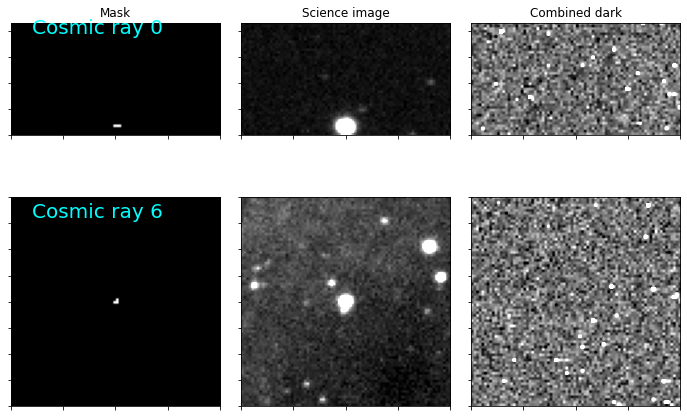

In [25]:
display_cosmic_rays(crs, images_to_display, titles=image_titles, only_display_rays=[0, 6])

## Guardado de los *lights* procesados

En este momento podríamos guardar las imágenes intermedias procesadas antes de apilarlas (pero no lo vamos a hacer).

## Alineado de *lights*

Antes de apilar los *lights* debemos alinearlos para que al realizar el *stacking* se encuentren todas las fuentes en la misma posición. 

### Haciendo nuestro propio alineado

Para alinear estrellas tenemos que tener en cuenta que pueden estar rotadas y desplazadas (no tenemos en cuenta otras deformaciones o ampliaciones). La rotación no aparecerá normalmente si tomamos los *lights* en una misma sesión, pero si puede ocurrir si tomamos  imágenes de distintas noches. Por lo tanto, nuestro codigo de alineado tendrá dos partes:

- Rotación
- Traslación

#### Rotación

In [26]:
from scipy.ndimage.interpolation import rotate
import pandas as pd
from photutils.detection import find_peaks
import math
def rotar_imagen(data):
    x = [] # voy a meter en esta lista la posicion de las estrellas mas brillantes en orden descendiente
    y = []
    
    #deteccion de estrellas
    for i in range(len(data)):
        mean, median, std = sigma_clipped_stats(data[i], sigma=3.0)
        threshold = median + (5. * std)
        tbl = find_peaks(data[i], threshold, box_size=11)

        table_to_pandas = tbl.to_pandas() # paso la tabla de astropy a pandas para que sea mas comodo trabajar
        pandas_ordenado = table_to_pandas.sort_values('peak_value', ascending=False) # ordeno los valores de los picos obtenidos de orden descendiente
        pandas_ordenado = pandas_ordenado.reset_index() # reseteo de los indices del archivo de pandas
        x.append(pandas_ordenado['x_peak']) # asigno las coordenadas de cada pico a mi lista x
        y.append(pandas_ordenado['y_peak']) # asigno las coordenadas de cada pico a mi lista y
        
    angulo = [] # defino una lista vacia en la que voy a tener en cuenta el angulo de rotacion que hay que aplicar a cada imagen
    
    for i in range(len(data)):
        #angulo.append(math.degrees(math.atan2(y[i][1] - y[i][0], x[i][1] - x[i][0]))) # calculo el angulo entre dos puntos de la misma imagen
        angulo.append(round(math.degrees(math.atan2(y[i][1] - y[i][0], x[i][1] - x[i][0])))) # calculo el angulo entre dos puntos de la misma imagen
        
    data_derotado = [data[0], ] # aquí uso la funcion rotate(imagen, angulo_de_rotacion) de la biblioteca scipy
    for i in range(1,len(data)):
        if (angulo[0]-angulo[i] < 0):  # Comprobar esto
            data_derotado.append(rotate(data[i], angle=angulo[0]-angulo[i]))
            print(f"La imagen {i} está rotada {angulo[0]-angulo[i]} grados")
        else:
            data_derotado.append(rotate(data[i], angle=angulo[0]-angulo[i]))
            print(f"La imagen {i} está rotada {angulo[0]-angulo[i]} grados")
    return data_derotado

In [27]:
imagenes_rotadas = rotar_imagen(lights_correction)

La imagen 1 está rotada 0 grados
La imagen 2 está rotada 0 grados
La imagen 3 está rotada 0 grados
La imagen 4 está rotada 0 grados
La imagen 5 está rotada 0 grados


#### Traslación

In [28]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

In [29]:
def desplazar_imagen(data):
    x = [] #hago una nueva lista vacia para meter de nuevo las coordenadas de las estrellas
    y = []
    
    for i in range(len(data)):
        mean, median, std = sigma_clipped_stats(data[i], sigma=3.0)
        threshold = median + (5. * std)
        tbl = find_peaks(data[i], threshold, box_size=11) 
        x.append(tbl[np.where(tbl['peak_value'] == tbl['peak_value'].max())[0][0]]['x_peak']) #solo me hace falta un punto, el mas brillante de cada imagen para desplazarla
        y.append(tbl[np.where(tbl['peak_value'] == tbl['peak_value'].max())[0][0]]['y_peak'])
    
    data_shift = [data[0], ]
    
    for i in range(1, len(data)):
        data_shift.append(shift_image(data[i], x[0]-x[i], y[0]-y[i])) #mediante la funcion shift_image desplazo cada imagen con respecto la primera
        print(f"La imagen {i} se ha desplazado en (x, y) = ({x[0]-x[i]}, {y[0]-y[i]})")
    return data_shift

In [30]:
imagenes_desplazadas = desplazar_imagen(imagenes_rotadas)

La imagen 1 se ha desplazado en (x, y) = (2, 1)
La imagen 2 se ha desplazado en (x, y) = (0, -3)
La imagen 3 se ha desplazado en (x, y) = (-1, 1)
La imagen 4 se ha desplazado en (x, y) = (1, -5)
La imagen 5 se ha desplazado en (x, y) = (4, -8)


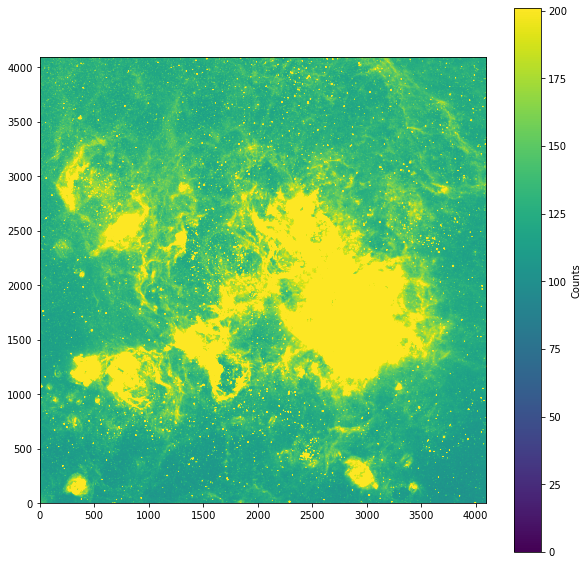

In [31]:
n_imagen = 2
plt.figure(f"Light {lights_list[n_imagen]}", figsize=[10, 10])
plt.imshow(imagenes_desplazadas[n_imagen], vmin=np.min(imagenes_desplazadas[n_imagen]), vmax=np.mean(imagenes_desplazadas[n_imagen])*1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

### Alineado mediante ```Astroalign```

```Astroalign``` es un paquete que alinea dos imágenes astronómicas buscando asterismos de tres puntos (tres estrellas) en común entre las dos imágenes, y realizando una transformación afín entre ellas.
El autor del paquete ```Astroalign``` es Martin Beroiz ([astroalign](https://github.com/toros-astro/astroalign)).

Para la instalacion de ```Astroalign```:
```
> conda install -c conda-forge astroalign
```

In [32]:
import astroalign
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits as ft


def imprimir_info(p, ii):
    # Esta función imprime por pantalla la info de la transformación que se aplicará.
    # Aunque es innecesaria, sirve para que el usuario sepa que la máquina está haciendo algo.
    print("\nAlineando imagen {:}".format(ii))
    print("Rotación: {:.2f} grados".format(p.rotation * 180.0 / np.pi))
    print("Factor de escala: {:.2f}".format(p.scale))
    print("Traslación: (x, y) = ({:.2f}, {:.2f})".format(*p.translation))


def registra_lista(lista):
    cantidad=len(lista)
    
    # La primera imagen de la lista será la toma de referencia.
    print("\nComenzando la alineación.")
    print("\nLa toma de referencia es {:}".format(lista[0])) 
    blanco=ft.open(lista[0])
    img_blanco=blanco[0].data
    hdr_blanco=blanco[0].header
    blanco.close()
    del(lista[0]) # Quito la imagen de referencia del listado
    imagenes_alineadas = [img_blanco, ]
    for ii in lista:
        ff=ft.open(ii)
        img_torcida=ff[0].data
        hdr_torcida=ff[0].header
        ff.close()
        p, (pos_img, pos_img_rot) = astroalign.find_transform(img_torcida, img_blanco)
        imprimir_info(p, ii)
        img_aligned = astroalign.register(img_torcida, img_blanco)
        hdr_torcida.add_comment("Registrado con Astroalign y PyReduc")
        imagenes_alineadas.append(img_aligned[0])
#        ft.writeto(f'imagenes\salidaImagenes\aling{}',img_aligned,header=hdr_torcida,overwrite=True)

    print("\nAlineado realizado con éxito")
    return imagenes_alineadas


In [33]:
len(lights_list)

6

In [34]:
imagenes_alineadas = registra_lista(lights_list)


Comenzando la alineación.

La toma de referencia es imagenes/calibracionImagenes/ha/NGC2070-20200208@030339-300S-H-alpha.fit

Alineando imagen imagenes/calibracionImagenes/ha/NGC2070-20200208@031223-300S-H-alpha.fit
Rotación: 0.00 grados
Factor de escala: 1.00
Traslación: (x, y) = (2.60, 0.44)

Alineando imagen imagenes/calibracionImagenes/ha/NGC2070-20200208@031915-300S-H-alpha.fit
Rotación: -0.01 grados
Factor de escala: 1.00
Traslación: (x, y) = (-0.01, -2.86)

Alineando imagen imagenes/calibracionImagenes/ha/NGC2070-20200208@032604-300S-H-alpha.fit
Rotación: -0.00 grados
Factor de escala: 1.00
Traslación: (x, y) = (-0.86, 0.25)

Alineando imagen imagenes/calibracionImagenes/ha/NGC2070-20200208@033255-300S-H-alpha.fit
Rotación: -0.01 grados
Factor de escala: 1.00
Traslación: (x, y) = (0.27, -5.46)

Alineando imagen imagenes/calibracionImagenes/ha/NGC2070-20200208@034446-300S-H-alpha.fit
Rotación: -0.12 grados
Factor de escala: 1.00
Traslación: (x, y) = (-5.42, -5.84)

Alineado real

## Apilado de *lights*

In [35]:
imagenFinal = np.nanmedian(imagenes_desplazadas, axis=0)

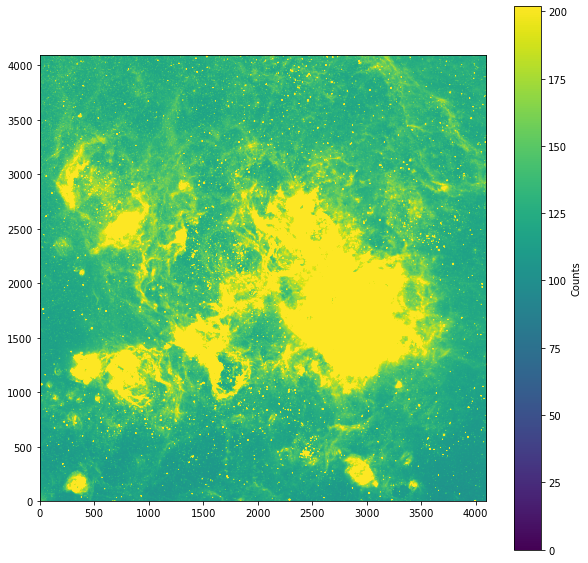

In [36]:
plt.figure(f"Light", figsize=[10, 10])
plt.imshow(imagenFinal, vmin=np.min(imagenFinal), vmax=np.mean(imagenFinal)*1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

## Guardado del *light* final

In [37]:
hdu_imagenFinal = fits.PrimaryHDU(data=imagenFinal.astype(np.float32), header=header_lights[0])
hdu_imagenFinal.writeto(directorioCalibracion + "imagenFinal.fit",overwrite=True)